# Stock Data 

We  considered  a  five-dimensional  set  of  data  (oil,  S&P  500,  usd/eur,  usd/yuan)  ,i.e.   toknow the dependence structure between oil price, the S& P 500 index and some currencyexchange rates w.r.t USD. The time series data consists of 1000 daily log-returns from May 2016 to April 2020

In [1]:
!pip install seaborn
!pip install yfinance
!pip install matplotlib
!pip install copulas
!pip install ambhas
!pip install copulae
!pip install factor_analyzer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import invgamma, chi2, t
import math
import yfinance as yf
import seaborn
import seaborn as sns; sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from scipy.optimize import minimize


### Generating Test statistic 

In [3]:
# Defines required functions 

# Student T distribution Multivariate random function
# Sig - Covariance Matrix for T copula
# df - degrees of freedom for T copula
# Size - No of samples to be generated
def tMultivariate_rand(Sig, df, size):
    (m,n) = Sig.shape
    s = np.diag(Sig)
    s_not_1 = s != 1
    if any(s_not_1):
        Sig = Sig/np.sqrt(s*s.T)
    T = np.linalg.cholesky(Sig)
        
    ra = np.dot(np.random.randn(size,len(T)),T)
    x = np.sqrt(nu/chi2.rvs(df, size=size)[:, np.newaxis])
    ra = ra*x    # No need the ./x(:,ones(n,1)) as Python does elem by elem operations
    if(df>2):
        ra=ra*(df/(df-2))
    return ra

# This function generates random Student T Copula 
def tCopula_rand(Rho, nu, d, n):
    multiVar = tMultivariate_rand(Rho, d, n)
    u = stats.t.cdf(multiVar,nu)
    return u

# takes i,j and returns index of it in the vectorize function
# is used in correlation estimator matrix
def indexMappingFunc(i, j):
    index = -1
    for k in range(1,i):
        for l in range(0,k):
            index = index+1
        
    for m in range(0,j+1):
        index = index+1
    return index

# for given i, j get kendalls tau value
def kendalls_tau(U, i, j, k, l):
    n,d = U.shape
    snij = 0
    snkl = 0
    snijkl = 0 
    for p in range(0, n-1):
        for q in range(0,p-1):
            snij = snij + np.sign((U[p][i]-U[q][i])*(U[p][j]-U[q][j]))
            snkl = snkl + np.sign((U[p][k]-U[q][k])*(U[p][l]-U[q][l]))
        snijkl = snijkl + (snij*snkl)

    snijkl = (snijkl/(n*(n-1)*(n-1)))
    snij = ((snij*2)/(n*(n-1)))
    snkl = ((snkl*2)/(n*(n-1)))
    return snij, snkl, snijkl

# Given a multivariate Copula matrix
# Generates kendalls estimators
def Kendalls_estimators(U):
    n,d = U.shape
    t = np.identity(d)
    dim = int((d*(d-1)/2))
    T = np.identity(dim)
    snij = 0 
    snkl = 0
    snijkl = 0
    for i in range(1,d):
        for j in range(0,i):
            for k in range(1,d):
                for l in range(0,k):
                    snij, snkl, snijkl = kendalls_tau(U, i, j, k, l)
                    #print(i, j , k , l)
                    t[i][j] = snij
                    t[j][i] = snij
                    t[k][l] = snkl
                    t[l][k] = snkl
                    a = indexMappingFunc(i,j)
                    b = indexMappingFunc(k,l)
                    T[a][b] = snijkl
                    T[b][a] = snijkl
    return t, T

#Vectorize the correlation matrix to a vector with non repeating elements
def vectorize(C):
    n,n = C.shape
    vec = []
    for i in range(1,n):
        for j in range(0,i):
            vec.append(C[i][j])
    return vec

#Devectorizes a vector to the correlation matrix with non repeating elements
def devectorize(arr):
    n = len(arr)
    d = int(np.sqrt(n*2))+1
    C = np.identity(d)
    c = 0 
    for i in range(1,d):
        for j in range(0,i):
            C[i][j] = arr[c]
            C[j][i] = arr[c]
            c = c+1
    return C

#Generate Kendalls T matrix estimate
#Returns a matrix
def Kendalls_tau_matrix(T, t, d):
    n, n = T.shape
    Testimate = np.identity(n)
    for i in range(1,d):
        for j in range(0,i):
            for k in range(1,d):
                for l in range(0,k):
                    a = indexMappingFunc(i,j)
                    b = indexMappingFunc(k,l)
                    #print(i,j,k,l,a,b)
                    Tval = T[a][b]
                    stat = (math.pi*math.pi)*math.cos(math.pi*float(t[i][j])*0.5)*math.cos(math.pi*float(t[k][l])*0.5)*(Tval - t[i][j]*t[k][l])
                    Testimate[a][b] = stat
                    Testimate[b][a] = stat
                    
    return Testimate


def generateTestStatisticTau(U):
    #Estimate kendalls tau and Kendalls estimator matrix
    #t -> Kendalls tau matrix
    #T -> Kendalls Tau based correlation estimator
    t, T = Kendalls_estimators(U)
    d, d = t.shape 
    # Calculate the optimized test statistic
    # the Kendalls tau related correlation estimator
    # r = sin(pi/2*T) where T is kendals tau matrix
    tvec = vectorize(t)
    RTau = [(math.pi)*float(i)*0.5 for i in tvec] 
    #RTau = math.sin((math.pi/2)*float(tvec))
    
    Testimate = Kendalls_tau_matrix(T, t, d)
    TestInv = np.linalg.inv(Testimate)
    # Quadratic descrepancy function
    # D = ((r-RTau)^T)*(T^-1)*(r-RTau)
    #print(len(r))

    return RTau, TestInv

def generateTestStatisticRho(U, r):
    #Estimate kendalls tau and Kendalls estimator matrix
    #t -> Kendalls tau matrix
    #T -> Kendalls Tau based correlation estimator
    t, T = Kendalls_estimators(U)
    d, d = t.shape 
    # Calculate the optimized test statistic
    # the Kendalls tau related correlation estimator
    # r = sin(pi/2*T) where T is kendals tau matrix
    tvec = vectorize(t)
    RTau = [(math.pi)*float(i)*0.5 for i in tvec] 
    #RTau = math.sin((math.pi/2)*float(tvec))
    
    Testimate = Kendalls_tau_matrix(T, t, d)
    TestInv = np.linalg.inv(Testimate)
    # Quadratic descrepancy function
    # D = ((r-RTau)^T)*(T^-1)*(r-RTau)
    #print(len(r))

    return r, TestInv


def optimfunction(RTau, TestInv, rinit):
    #if simulation - use r, otherwise r[i] - variable
    
    diff = np.array([rinit[i]-RTau[i] for i in range(0,len(rinit))])
    return ((diff).transpose()*TestInv*(diff)).min()
    

### Stock Data 

We  considered  a  five-dimensional  set  of  data  (oil,  S&P  500,  usd/eur,  usd/yuan). 
Download the corresponding data from yahoo finance and get the log returns.
Each security's data is downloade and plotted to understand the patterns in the last 5 years. 

In [4]:
import matplotlib.pyplot as plt

# Get real data for oil, S&P500, eur and usd

#Oil Prices
oilt = yf.Ticker("CL=F")
#print(oilt.info)
oilC = oilt.history(period="1500d")['Close'].pct_change()
oilLog = np.log(1+oilC).to_frame()

#S&P500
SnP500t = yf.Ticker("^GSPC")
#print(SnP500t.info)
SnP500C = SnP500t.history(period="1500d")['Close'].pct_change()
SnP500Log = np.log(1+SnP500C).to_frame()


#USD/EUR Exchange rate
UsdEurt = yf.Ticker("USDEUR=X")
#print(UsdEurt.info)
UsdEurC = UsdEurt.history(period="1500d")['Close'].pct_change()
UsdEurLog = np.log(1+UsdEurC).to_frame()

#Gold Prices
Goldt = yf.Ticker("GC=F")
#print(Goldt.info)
GoldC = Goldt.history(period="1500d")['Close'].pct_change()
GoldLog = np.log(1+GoldC).to_frame()

#USD Yuan exchange rate
UsdYuant = yf.Ticker("USDCNY=X")
#print(UsdYuant.info)
UsdYuanC = UsdYuant.history(period="1500d")['Close'].pct_change()
UsdYuanLog = np.log(1+UsdYuanC).to_frame()


/Users/greeshmab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


The data downloaded for each security is then converted into Dataframe in order to process. 
All the missing data with values NA is removed i.e all the data for 5 securities for the date on which the data is missing is deleted. 

We plotted data for last 3 months to understand COVID 19 effect. It can be clearly noticed that Gold is bullish where as oil and market are down. There aren't any significant pattern in exchange rates since all the major economies are affected similarly due to this pandemic. 

(1002, 5)


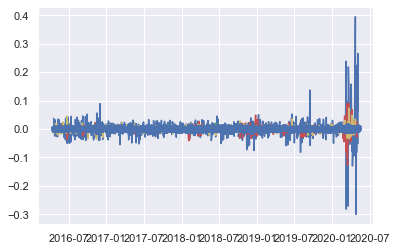

<Figure size 432x288 with 0 Axes>

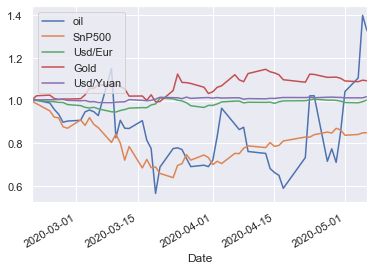

In [5]:
#Data is missing for some dates - hence merge it by date as key
df = pd.concat([oilLog['Close'], SnP500Log['Close'], UsdEurLog['Close'], GoldLog['Close'], UsdYuanLog['Close']], axis=1)
# Drop NA values
df.dropna(inplace = True) 
#Returns (1223, 5)
#Removing 223 days to get matrix of size 1000
dfa = df.iloc[223:]
dfa.columns = ['oil', 'SnP500', 'Usd/Eur', 'Gold', 'Usd/Yuan']
#Convert the data into matrix for the analysis
retDf = dfa.to_numpy()

print(retDf.shape)  #Returns (1000, 5)
#print(dfa.head)

dfarecent = dfa[:][950:]

plt.plot(dfa['oil'], '-b', label='oil')
plt.plot(dfa['SnP500'], '-r', label='SnP')
plt.plot(dfa['Usd/Eur'],'-g', label='Usd/Eur')
plt.plot(dfa['Gold'], '-y', label='Gold')
plt.plot(dfa['Usd/Yuan'], '-p', label='Usd/Yuan')
fig = plt.figure()
(dfarecent + 1).cumprod().plot()
plt.show()


### Goodness of Fit test
Before we apply our method to real life data, we must either verify or falsifying the assumption of an elliptical copula. For the parametric tests dependence structure of a data set is really app Information criteria, such as Akaike's informa about the power of the decision rule that is em been suggested by various researchers and we (2007) for discussions of existing methods. We tried to fit both normal and t-copula for the whole data set and tested goodness of fitGoodness of fit is done using Parametric bootstrap goodness-of-fit test with Kendall KStest and normal copula and t copula.

In [6]:
from copulae import NormalCopula
from copulae import TCopula
import numpy as np

np.random.seed(8)
#data = np.random.normal(size=(300, 8))
cop = NormalCopula(5)
cop.fit(retDf)

cop.random(10)  # simulate random number

# getting parameters
p = cop.params
# cop.params = ...  # you can override parameters too, even after it's fitted!  

# get a summary of the copula. If it's fitted, fit details will be present too
print(cop.summary())

# overriding parameters, for Elliptical Copulae, you can override the correlation matrix
cop[:] = np.eye(8)  # in this case, this will be equivalent to an Independent Copula

Gaussian Copula Summary
Gaussian Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.134054 -0.012386  0.083699  0.000792
 0.134054  1.000000 -0.057918 -0.126398 -0.010113
-0.012386 -0.057918  1.000000 -0.033851  0.363483
 0.083699 -0.126398 -0.033851  1.000000 -0.014861
 0.000792 -0.010113  0.363483 -0.014861  1.000000



                                  Fit Summary                                   
Log. Likelihood      : -94.1307355870704
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1002

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.0

In [7]:
np.random.seed(8)
#data = np.random.normal(size=(300, 8))
cop = TCopula(5)
cop.fit(retDf)

cop.random(10)  # simulate random number

# getting parameters
p = cop.params
# cop.params = ...  # you can override parameters too, even after it's fitted!  

# get a summary of the copula. If it's fitted, fit details will be present too
print(cop.summary())

# overriding parameters, for Elliptical Copulae, you can override the correlation matrix
cop[:] = np.eye(8)  # in this case, this will be equivalent to an Independent Copula

Student Copula Summary
Student Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 8.223078185479086

 Correlation Matrix 
 1.000000  0.188386 -0.014565  0.075615  0.012343
 0.188386  1.000000 -0.050432 -0.126084 -0.033721
-0.014565 -0.050432  1.000000 -0.030203  0.359785
 0.075615 -0.126084 -0.030203  1.000000 -0.003216
 0.012343 -0.033721  0.359785 -0.003216  1.000000



                                  Fit Summary                                   
Log. Likelihood      : -149.52314045577384
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1002

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(0.0, inf), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001)

In [8]:
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn import decomposition
from sklearn.decomposition import FactorAnalysis
from scipy.stats import pearsonr
import pandas as pd


### Test Statistic Calculations
In order to calculate the optimal min value of test statistic, we used python SciPyoptimize and fmin() function. It uses a Nelder-Mead simplex algorithm to find theminimum of function of one or more variables.•For the initial value, we used Factor Analysis from sklearn.  decomposition FactorAnalysis which is a simple linear generative model with Gaussian Latent Variables.

In [9]:
fa = FactorAnalyzer()
fa.fit(retDf)
#fa.analyze(df, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("Eigen values are :")
print(ev)


print("Corellation matrix is: ")
#Sklearn function does not standarize your data while R facanal() does
r = dfa.corr(method='pearson')

print(r)
print(retDf.shape)


Eigen values are :
[1.36185594 1.17395184 0.96206576 0.87021357 0.63191289]
Corellation matrix is: 
               oil    SnP500   Usd/Eur      Gold  Usd/Yuan
oil       1.000000 -0.093590  0.020592  0.114331 -0.010169
SnP500   -0.093590  1.000000 -0.068356 -0.045525  0.037782
Usd/Eur   0.020592 -0.068356  1.000000 -0.055147  0.350542
Gold      0.114331 -0.045525 -0.055147  1.000000 -0.032148
Usd/Yuan -0.010169  0.037782  0.350542 -0.032148  1.000000
(1002, 5)


In [10]:
factor = decomposition.FactorAnalysis(n_components=2)
factor.fit(retDf)
L = factor.components_
R = L.transpose().dot(L)

#Rvec is the vectorized version of correlation matrix
rvec = vectorize(r.as_matrix())

#rinit is the inintializer of loadings that are derived from standard factor analysis
#using  sklearn.decomposition import FactorAnalysis

rinit = vectorize(R)
Rtau, Testinv = generateTestStatisticTau(retDf)

RRho, Testinv = generateTestStatisticRho(retDf, rvec)

#Use optim function to minimize the T statistic and optimize the R(v) values
#We get factor loadings by building back R matrix and doing choleskey decomposition

print(len(Rtau))
print(len(rvec))
print(Testinv.shape)

print("T tau value is")
print(-1000*optimfunction(Rtau, Testinv, rinit))

restau = fmin(optimfunction, rinit, args=(Rtau, Testinv), full_output=True,disp=False)
 
print("T rho value is")


print(-1000*optimfunction(rvec, Testinv, rinit))

resrho = fmin(optimfunction, rinit, args=(rvec, Testinv), full_output=True,disp=False)

/Users/greeshmab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


10
10
(10, 10)
T tau value is
9.039817759341588
T rho value is
7.813051044949247


In [11]:
print(restau)
print(resrho)

LLt = devectorize(restau[0])
L = np.linalg.cholesky(LLt)
print(L)

(array([-4.31133600e-05,  3.91897053e-06, -2.80073395e-06,  3.16307833e-05,
       -5.93361490e-06, -1.83784998e-06, -2.21627370e-06, -3.70247077e-07,
        4.36199603e-06, -1.28794459e-06]), -0.0012430295172522223, 1, 11, 0)
(array([-4.31133600e-05,  3.91897053e-06, -2.80073395e-06,  3.16307833e-05,
       -5.93361490e-06, -1.92974248e-06, -2.21627370e-06, -3.52616264e-07,
        4.36199603e-06, -1.28794459e-06]), -0.002152727500441127, 1, 11, 0)
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.31133600e-05  9.99999999e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.91897053e-06 -2.80056499e-06  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.16307833e-05 -5.93225120e-06 -1.83799056e-06  9.99999999e-01
   0.00000000e+00]
 [-2.21627370e-06 -3.70342628e-07  4.36200367e-06 -1.28786867e-06
   1.00000000e+00]]


In [12]:
factor = decomposition.FactorAnalysis(n_components=3)
factor.fit(retDf)
L = factor.components_
R = L.transpose().dot(L)

#Rvec is the vectorized version of correlation matrix
rvec = vectorize(r.as_matrix())

#rinit is the inintializer of loadings that are derived from standard factor analysis
#using  sklearn.decomposition import FactorAnalysis

rinit = vectorize(R)
Rtau, Testinv = generateTestStatisticTau(retDf)

RRho, Testinv = generateTestStatisticRho(retDf, rvec)

#Use optim function to minimize the T statistic and optimize the R(v) values
#We get factor loadings by building back R matrix and doing choleskey decomposition

print(len(Rtau))
print(len(rvec))
print(Testinv.shape)

print("T tau value is")
print(-1000*optimfunction(Rtau, Testinv, rinit))

restau2 = fmin(optimfunction, rinit, args=(Rtau, Testinv), full_output=True,disp=False)
 
print("T rho value is")


print(-1000*optimfunction(rvec, Testinv, rinit))

resrho2 = fmin(optimfunction, rinit, args=(rvec, Testinv), full_output=True,disp=False)



/Users/greeshmab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


10
10
(10, 10)
T tau value is
9.039816973853851
T rho value is
7.813050314702046


We get optimal vec(R) value. We need to devectorize to get the R - correlation matrix. We then do the SVD decomposition to get the Factor loadings and plot them.

In [13]:
#Gets the spearmans correlation estimator and SVD analysis gives factor loadings
temp = devectorize(resrho[0])
u,s,vh = np.linalg.svd(temp)

print("Loadings for factor 1 ")
print(u[:,0])

print("Loadings for factor 2 ")
print(u[:,1])

print("Eigen values for SVD decomposition")
print(np.diag(s))


Loadings for factor 1 
[-0.6875042   0.57216751 -0.05854416 -0.4423809   0.02887962]
Loadings for factor 2 
[ 0.00074961 -0.14855539  0.70427659 -0.24408106  0.64988434]
Eigen values for SVD decomposition
[[1.00005666 0.         0.         0.         0.        ]
 [0.         1.00000529 0.         0.         0.        ]
 [0.         0.         0.99999627 0.         0.        ]
 [0.         0.         0.         0.99999265 0.        ]
 [0.         0.         0.         0.         0.99994913]]


In [14]:
#Gets the Kendalls correlation estimator and SVD analysis gives factor loadings

temp = devectorize(restau[0])
u,s,vh = np.linalg.svd(temp)

print("Loadings for factor 1 ")
print(u[:,0])

print("Loadings for factor 2 ")
print(u[:,1])

print("Eigen values for SVD decomposition")
print(np.diag(s))



Loadings for factor 1 
[ 0.68747374 -0.57213162  0.05927117  0.44239325 -0.02864281]
Loadings for factor 2 
[-1.95479812e-04 -1.46594498e-01  7.03217077e-01 -2.41249587e-01
  6.52529229e-01]
Eigen values for SVD decomposition
[[1.00005666 0.         0.         0.         0.        ]
 [0.         1.00000526 0.         0.         0.        ]
 [0.         0.         0.99999623 0.         0.        ]
 [0.         0.         0.         0.99999271 0.        ]
 [0.         0.         0.         0.         0.99994913]]


For the initial value, we used Factor Analysis from sklearn.  decomposition FactorAnalysis which is a simple linear generative model with Gaussian Latent Variables.
* For Factor 1 : We can observe that both exchange currency rates are near zero. But oil,gold are negative. S&P500 which is a benchmark index is positive. We can interpretthis as a commodity factor
* For Factor 2: We see that both exchange rates are negative , near to -1. Whereasthe oil, SnP500 and gold are near zero. This is a factor which is not even tracked bybenchmark. We can call this as currency factor.

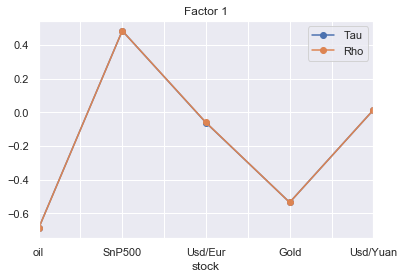

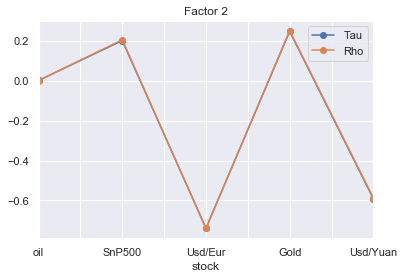

In [15]:
#Factor 1
df1 = pd.DataFrame({"stock": ['oil', 'SnP500','Usd/Eur','Gold','Usd/Yuan'],
                   "Tau" : [-0.68894582, 0.48562668, -0.06074125, -0.53442184, 0.01497244],
                   "Rho" : [-0.68900362, 0.48564336, -0.05955055, -0.53446329, 0.01507526] })
df2 = pd.DataFrame({"stock": ['oil', 'SnP500','Usd/Eur','Gold','Usd/Yuan'],
                   "Tau" : [0.00230484, 0.2025604, -0.73951464, 0.2485645,  -0.59185957],
                   "Rho" : [0.00124429,  0.20623856, -0.74066372,  0.25174185, -0.58779877] })
df1.plot(x="stock", y=["Tau", "Rho"], style='-o', title = "Factor 1")
plt.show()
df2.plot(x="stock", y=["Tau", "Rho"], style='-o', title = "Factor 2")
plt.show()

